In [1]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
df = pd.read_csv('./src/conversion_data_train.csv')
df.shape

(284580, 6)

In [5]:
categ_str_features = ['country', 'source']
categ_int_features = ['new_user']
numeric_features = ['age', 'total_pages_visited']
target = 'converted'

In [6]:
X = df.iloc[:, :-1]
y = df.loc[:, 'converted']

### Deal with Unbalanced Data : SMOTETomek

In [8]:
onehot = OneHotEncoder(drop='first')
X = onehot.fit_transform(X)

In [10]:
smt = SMOTETomek(random_state=42,n_jobs=-1)
X_res, y_res = smt.fit_resample(X, y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.15, random_state=0, stratify=y_res)

In [19]:
numeric_features = ['age', 'total_pages_visited']
categ_features = ['country', 'source', 'new_user']
# numeric_features = ['total_pages_visited']
# categ_features = ['new_user']

num_transf = make_pipeline(
    (SimpleImputer(strategy='mean')),
    (StandardScaler())
)

categ_transf = OneHotEncoder(drop='first')

preprocessor = make_column_transformer(
    (num_transf, numeric_features),
    (categ_transf, categ_features)
)

### Logistic Regression

In [29]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

LogisticRegression()

In [30]:
params = {
    'C' : [1.025, 1.027, 1.029, 1.031, 1.032,1.034],
    'penalty' : ['l1','l2']
}

gridsearch_lr = GridSearchCV(lr, param_grid = params, cv=10)
gridsearch_lr.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [1.025, 1.027, 1.029, 1.031, 1.032, 1.034],
                         'penalty': ['l1', 'l2']})

In [31]:
print("Best hyperparameters : ", gridsearch_lr.best_params_)
print("Best R2 score : ", gridsearch_lr.best_score_)

Best hyperparameters :  {'C': 1.034, 'penalty': 'l2'}
Best R2 score :  0.9505019436968686


In [32]:
y_train_pred_lr = gridsearch_lr.predict(X_train)
y_test_pred_lr = gridsearch_lr.predict(X_test)

In [33]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.9506967185154864
f1-score sur le test set :  0.9501959266605389


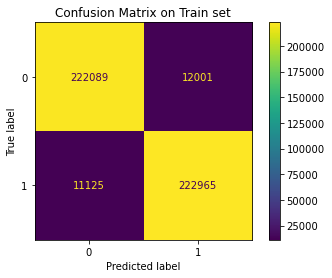

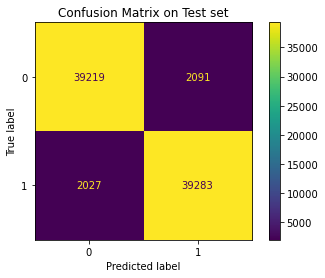

In [34]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(gridsearch_lr, X_test, y_test, ax=ax) 
plt.show()

### XGBoost

In [7]:
xgboost = XGBClassifier()

params = {
    'max_depth': [4,5,6,7,8], 
    'min_child_weight': [3.5,4.0,5.0], 
    'n_estimators': [14,15,17,20] 
}

xgboost_gs = GridSearchCV(xgboost, param_grid = params, cv=10) 
xgboost_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [3.5, 4.0, 5.0],
                         'n_estimators': [14, 15, 17, 20]})

In [9]:
print("Best hyperparameters : ", xgboost_gs.best_params_)
print("Best R2 score : ", xgboost_gs.best_score_)

Best hyperparameters :  {'max_depth': 8, 'min_child_weight': 5.0, 'n_estimators': 20}
Best R2 score :  0.9431757016532103


In [10]:
y_train_pred_lr = xgboost_gs.predict(X_train)
y_test_pred_lr = xgboost_gs.predict(X_test)

In [11]:
print("f1-score sur le train set : ", f1_score(y_train, y_train_pred_lr))
print("f1-score sur le test set : ", f1_score(y_test, y_test_pred_lr))

f1-score sur le train set :  0.9441076357724678
f1-score sur le test set :  0.9427337093483739


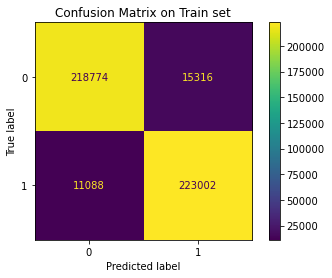

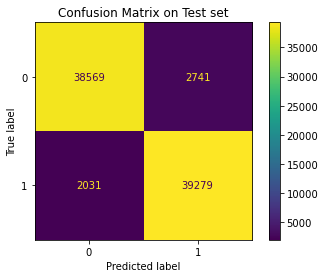

In [12]:
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(xgboost_gs, X_train, y_train, ax=ax) 
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_estimator(xgboost_gs, X_test, y_test, ax=ax) 
plt.show()

In [43]:
X_res_df = pd.DataFrame(X_res)

,0
0,"(0, 7)\t1.0\n (0, 62)\t1.0\n (0, 63)\t1.0\..."
1,"(0, 1)\t1.0\n (0, 6)\t1.0\n (0, 62)\t1.0\n..."
2,"(0, 0)\t1.0\n (0, 5)\t1.0\n (0, 64)\t1.0\n..."
3,"(0, 2)\t1.0\n (0, 8)\t1.0\n (0, 62)\t1.0\n..."
4,"(0, 2)\t1.0\n (0, 13)\t1.0\n (0, 62)\t1.0\..."
...,...
550795,"(0, 79)\t1.0\n (0, 64)\t1.0\n (0, 8)\t1.0\..."
550796,"(0, 69)\t1.0\n (0, 64)\t0.09729176726242972..."
550797,"(0, 75)\t1.0\n (0, 64)\t1.0\n (0, 62)\t1.0..."
550798,"(0, 76)\t1.0\n (0, 6)\t1.0\n (0, 2)\t1.0"


In [54]:
X_res_df = pd.DataFrame(X_res.todense())
X_res_df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550798,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
smote_df = pd.concat([X_res_df,y_res],axis=1)

In [53]:
smote_df.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,converted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [55]:
smote_df.to_csv("./src/smote_df.csv", index=False)

### Work with SMOTE

In [3]:
df_smote = pd.read_csv("./src/smote_df.csv")
df_smote

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,converted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550795,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550796,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
550798,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
X = df_smote.iloc[:,:-1]
y = df_smote['converted']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [13]:
df = pd.read_csv('conversion_data_train.csv')

X = df.iloc[:,:-1]
y = df['converted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0, stratify=y)

In [ ]:
xgboost_gs.predict(X_train)
# y_test_pred_lr = xgboost_gs.predict(X_test)